# <center>UE 4.1 - Machine Learning </center>

UE 4.1 Machine Learning
Noms et prénoms : GETA Rayane, AZOU Raphaël


### Imports

In [9]:
import numpy as np
import sklearn as sk
import os
import cv2
from matplotlib import pyplot as plt
import skimage
from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar, rotate, rescale
from skimage.util import img_as_float
from sklearn.neighbors import KNeighborsClassifier
import random
import time 

path = "./images_ISAR"

---

## Partie I - Analyse de données ISAR

<div class="alert alert-info">
<h3 class="alert-heading"> Question 1 - Généralités sur la base de données</h3>

#### Lecture du fichier
Premièrement, on load le fichier zip contenant les images.

> Nombres d'images : 810
> Taille d'une image : (256, 256)


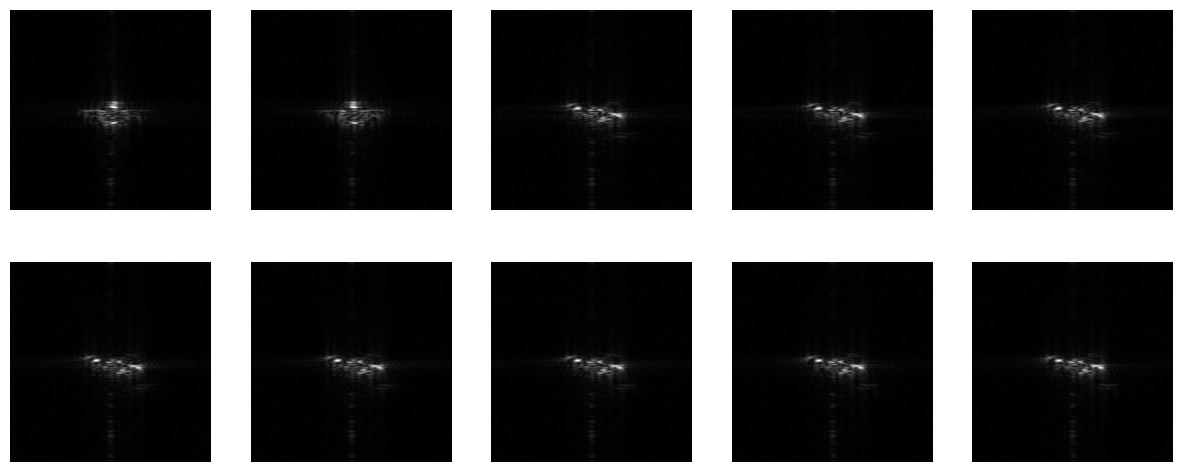

In [10]:
images = []
for image in os.listdir(path):
    img = cv2.imread(os.path.join(path,image),cv2.IMREAD_GRAYSCALE)
    if img is not None:
        images.append(img)

print("> Nombres d'images : "+ str(len(images)))
print("> Taille d'une image : "+ str(images[0].shape))

##Afficage de 10 d'entre elles
plt.subplots(2,5,figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')    
plt.show()

Il y a 810 images dans le dossier "images_ISAR".

#### Séparation des images par classes

In [11]:
# Store the image file names in a list as long as they are bmps
nom_images = [f for f in os.listdir(path) if os.path.splitext(f)[-1] == '.bmp']
type_appareil=[]
for k in nom_images:
    type_appareil.append(k.split("_")[0])  #split the names before the _

#print(type_appareil)
values, counts = np.unique(type_appareil, return_counts=True)  #count the number of different elements in the list

print("Classes :", values)
print("Nombre d'images par classe :", counts)


Classes : ['A10' 'F14' 'F15' 'F16' 'F4']
Nombre d'images par classe : [162 162 162 162 162]


#### Histogramme

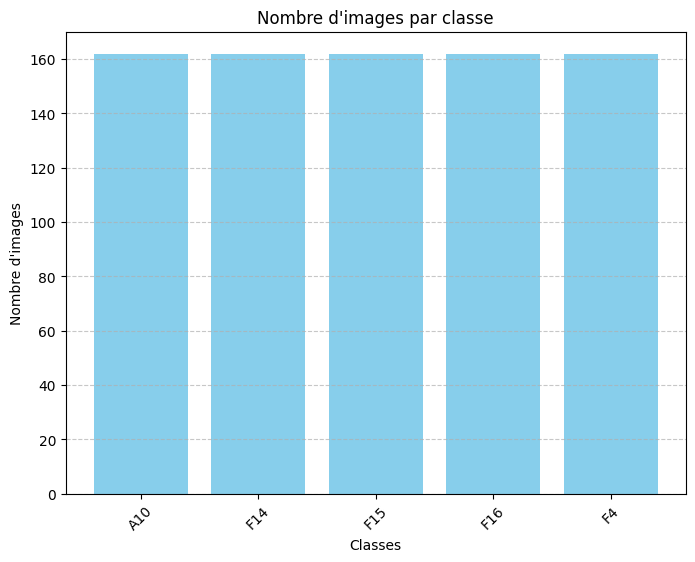

In [12]:

plt.figure(figsize=(8, 6))
plt.bar(values, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par classe')
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.show()

### Analyse
On constate que chaque classe contient le même nombre d'images, soit 162. Cela signifie que la base de données est équilibrée et qu'il n'y a pas de biais dans les données. Le modèle ne sera donc pas influencé par une classe plus représentée que les autres.



#### Dimension de l'espace de données

In [13]:
# a completer
print("> Dimension de l'espace de données : ",images[0].shape[0]*images[0].shape[1])
print("> Valeur maximale de l'espace de données : ",np.max(images[0]))
print("> Valeur minimale de l'espace de données : ",np.min(images[0]))

> Dimension de l'espace de données :  65536
> Valeur maximale de l'espace de données :  255
> Valeur minimale de l'espace de données :  0


### Commentaires 
Chaque image a une dimension de 256*256 pixels, soit 65536 pixels par image. Le modèle KPPV peut être lent et coûteux en calcul, car il doit stocker et comparer toutes les données d’entraînement pour chaque prédiction. Cela signifie qu'il n’est pas idéal pour les ensembles de données de grande taille. Il est donc dans notre intérêt de réduire la dimension de l'espace de données pour accélérer le processus de prédiction étant donné que pour les images que nous avons, les zones ayant le plus d'informations sont les zones centrales.

#### Réduction de la dimension des données



##### Affichage des niveaux de gris d'une image aléatoire

> Dimension de l'espace de données après réduction :  22500
> Gain de réduction de la dimension : 65.667724609375 %


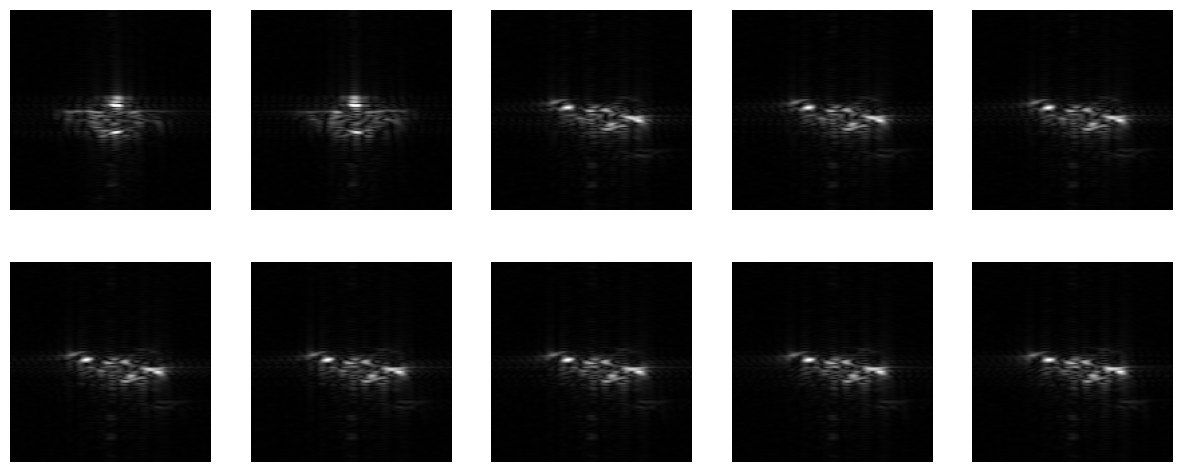

In [14]:
# Crop d'une image [256,256] -> [150,150]
cropSize = (150,150)
xmin = (images[0].shape[0] - cropSize[0])//2
xmax = xmin + cropSize[0]
ymin = (images[0].shape[1] - cropSize[1])//2
ymax = ymin + cropSize[1]

def crop(a):
    new=[]
    for i in range(len(a)):
        new.append(a[i][ymin:ymax,xmin:xmax])
    return new

def aff_grey(a):
    plt.imshow(a,cmap='gray')
    
cropped_images = crop(images)

plt.subplots(2,5,figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    aff_grey(cropped_images[i])
    plt.axis('off')

newDim = cropSize[0]*cropSize[1]
oldDim = images[0].shape[0]*images[0].shape[1]
gain_pourcentage = 100*abs(oldDim - newDim)/oldDim

print("> Dimension de l'espace de données après réduction : ", newDim)
print("> Gain de réduction de la dimension : " + str(gain_pourcentage) + " %")



Voici quelques images "croppées".

<div class="alert alert-info">
<h3 class="alert-heading"> Question 2 - Load BDD</h3>

Ici, on a une fonction qui à partir d'un dossier donné d'images (de format .bmp) renvoie la matrice des donneés et le vecteur des labels

In [15]:
import cv2
import os
import numpy as np


def load_bdd(directory):
    images = []  # Matrice de données (images mises à plat)
    label_list = []  # Vecteur des classes (labels)
    
    nom_images = [f for f in os.listdir(directory) if os.path.splitext(f)[-1] == '.bmp']
    
    labels = []
    for k in nom_images:
        labels.append(k.split("_")[0])
    
    for filename in nom_images:
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE) 
            if img is not None:
                images.append(img_as_float(img)) 
                label = filename.split("_")[0]
                label_list.append(label)
    
    data = np.array(crop(images)).reshape(len(images), -1)
    label_list = np.array(label_list)
    return data, label_list

directory = "./images_ISAR"
data, label = load_bdd(directory)
print("Matrice de données :", data.shape)
print("Vecteur des classes (labels) :", label.shape)



Matrice de données : (810, 22500)
Vecteur des classes (labels) : (810,)


## Partie II - Extraction des caractéristiques discriminantes – Image polaire

<div class="alert alert-info">
<h3 class="alert-heading"> Question 1 - Fonction polaire()</h3>

> Dimension de l'espace de données avant transformation polaire :  65536
> Dimension de l'espace de données après transformation polaire :  2500
> Gain de réduction de la dimension : 96.185302734375 %


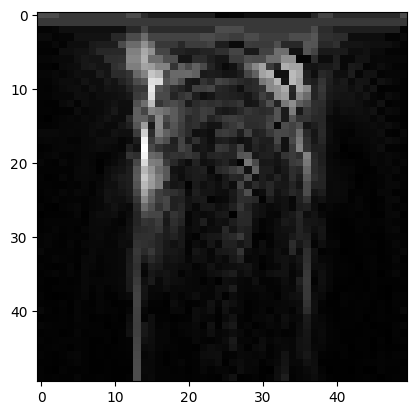

In [16]:
#Image aléatoire

image = random.choice(images)

# exemple de la fonction polaire
def polaire(image, Nr=50, Mtheta=50, Rmax=50):
    M, N = image.shape
    center_x, center_y = N//2, M//2
    polar_image = np.zeros((Nr, Mtheta))
    dtheta = 2*np.pi/(Mtheta-1)
    dr = Rmax/(Nr-1)
    for m in range(Nr):
        for n in range(Mtheta):
            theta = -np.pi + (n-1)*dtheta
            r = (m-1)*dr
            x = center_x + r*np.cos(theta)
            y = center_y + r*np.sin(theta)
            x, y = int(x), int(y)
            if x >= N or y >= M:
                continue
            polar_image[m,n] = image[x, y]

    return polar_image

# A compléter


polaire_image = polaire(image)
plt.imshow(polaire_image, cmap='gray')
newDim = polaire_image.shape[0]*polaire_image.shape[1]
oldDim = image.shape[0]*image.shape[1]
gain_pourcentage = 100*abs(oldDim - newDim)/oldDim

print("> Dimension de l'espace de données avant transformation polaire : ", oldDim)
print("> Dimension de l'espace de données après transformation polaire : ", newDim)
print("> Gain de réduction de la dimension : " + str(gain_pourcentage) + " %")

#### Commentaires
La représentation des images en coordonnées polaires permet de mettre en évidence les caractéristiques de l'image en réduisant davantage la dimension de l'espace de données.

<div class="alert alert-info">
<h3 class="alert-heading"> Question 2 - Invariances des images polaires</h3>

### Invariance par rotation

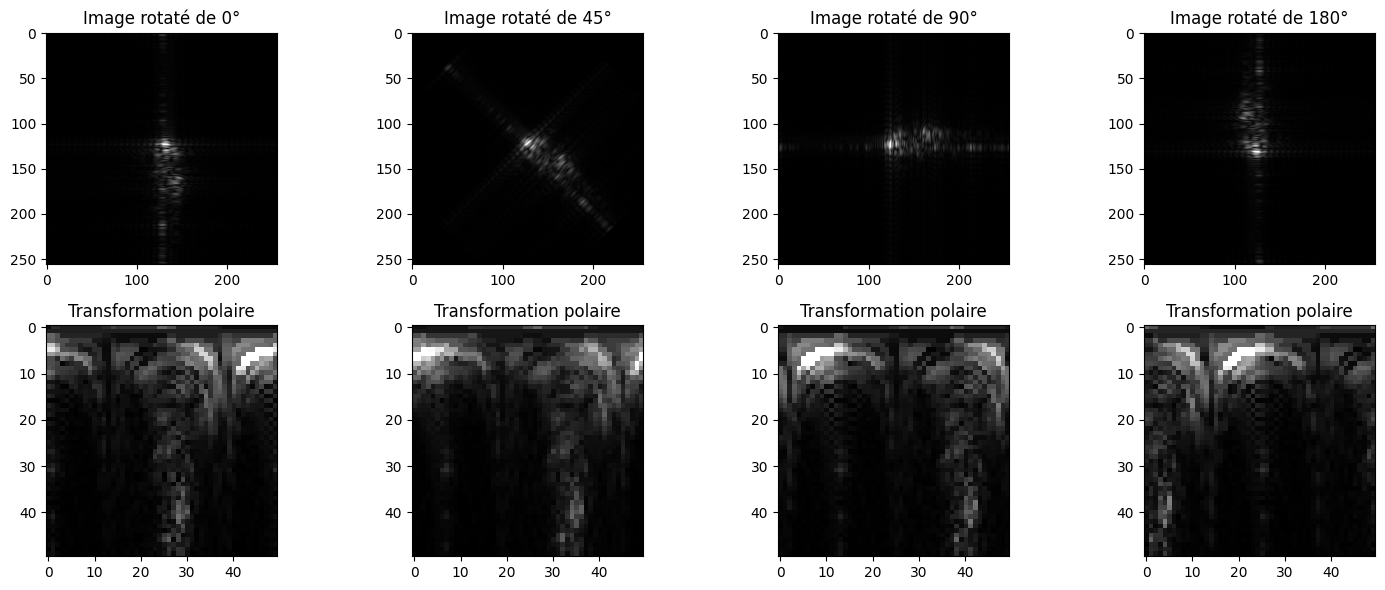

In [17]:
#
# Supposons que 'image' soit votre image d'origine
image = random.choice(images)

angles = [0,45,90,180]

cols_count = len(angles)
fig, axes = plt.subplots(2, cols_count, figsize=(15, 6))

for i in range(len(angles)):
    angle = angles[i]
    image_rotated = rotate(image, angle)
    image_polar = polaire(image_rotated)
    
    axes[0, i].imshow(image_rotated, cmap='gray')
    axes[0, i].set_title(f"Image rotaté de {angle}°")
    
    axes[1, i].imshow(image_polar, cmap='gray')
    axes[1, i].set_title(f"Transformation polaire")

plt.tight_layout()
plt.show()

### Commentaires
On constate que les images polaires ne sont pas invariantes par rotation.

### Invariance par changement d'échelle

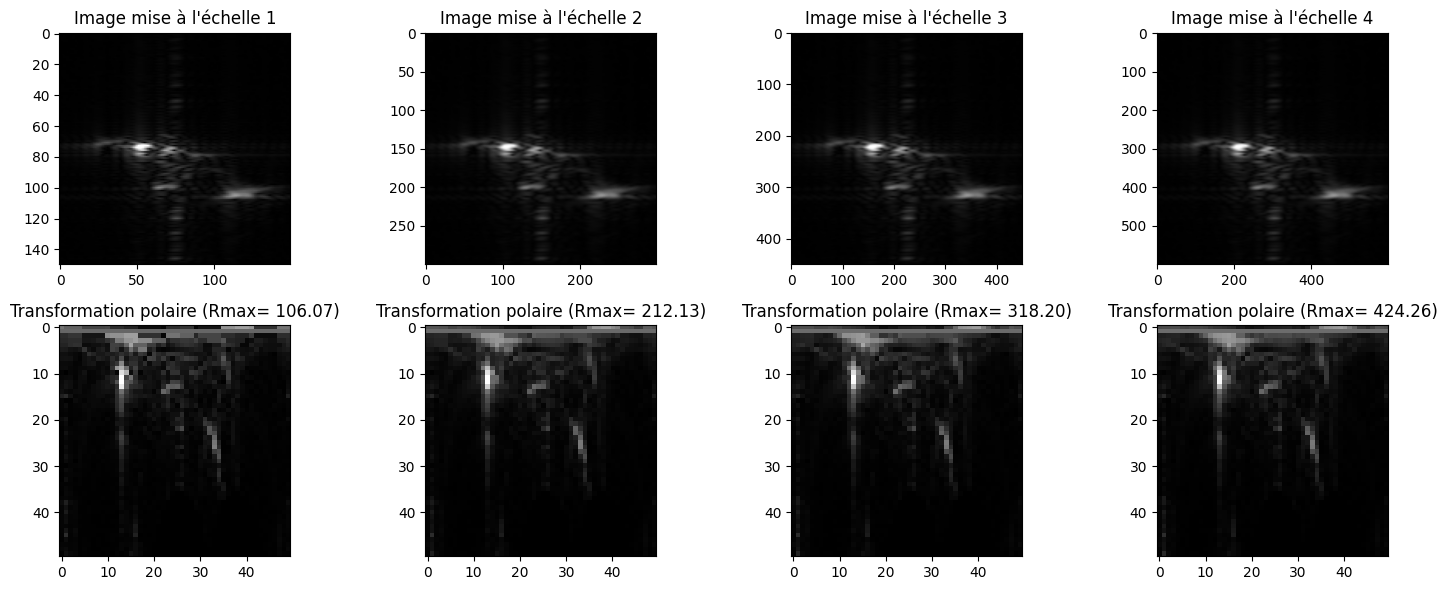

In [31]:

# Supposons que 'image' soit votre image d'origine
image = random.choice(cropped_images)
def scale_image_polar(image, scale, Nr, Mtheta, Rmax):
    image_scaled = rescale(image, scale)
    image_polar = polaire(image_scaled, Nr, Mtheta, Rmax)
    return image_polar


scales = [1,2,3,4]
cols_count = len(scales)
fig, axes = plt.subplots(2, cols_count, figsize=(15, 6))

for i in range(len(scales)):
    curr_scale = scales[i]
    image_scaled = rescale(image, curr_scale)
    rmax = image_scaled.shape[0]/np.sqrt(2)
    image_polar = polaire(image_scaled, 50, 50, rmax)
    
    axes[0, i].imshow(image_scaled, cmap='gray')
    axes[0, i].set_title(f"Image mise à l'échelle {curr_scale}")
    
    axes[1, i].imshow(image_polar, cmap='gray')
    axes[1, i].set_title(f"Transformation polaire (Rmax={rmax : .2f})")

plt.tight_layout()
plt.show()

#### Commentaire
On constate que la représentation en image polaire d'une image originale est quasiment invariante par changement d'échelle de cette image originale. La dimension de l'espace de représentation par pixel sur l'image polaire est toujours identique contrairement à celle de l'image originale dont l'échelle à été changée

### Invariance par changement d'échelle et rotation

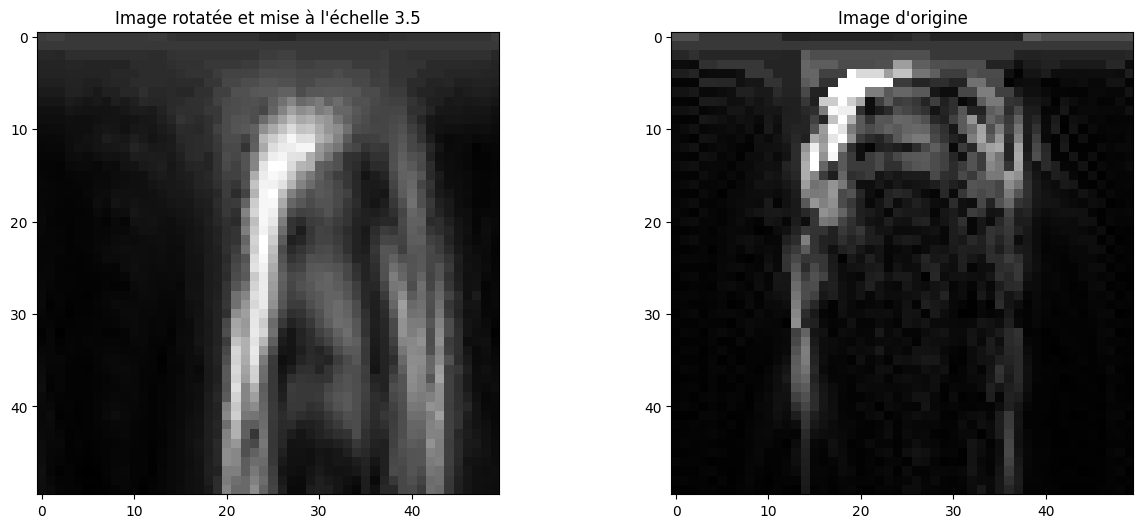

In [19]:
image = random.choice(images)
angle = 45
scale = 3.5

image_rotated = rotate(image, angle)
image_rotated_scaled = scale_image_polar(image_rotated, scale, 50, 50, 50)
plt.subplots(1,2,figsize=(15,6))

plt.subplot(1,2,1)
plt.imshow(polaire(image), cmap='gray')
plt.title("Image d'origine")

plt.subplot(1,2,2)
plt.imshow(image_rotated_scaled, cmap='gray')
plt.title(f"Image rotatée de {angle}° et mise à l'échelle {scale}")
plt.show()

L'image obtenue est de taille (50x50).

Question 3 - Nouveau vecteurs caractéristiques: $\mathbf{I}_{θ}$ et $\mathbf{I}_{\text{r}}$

In [20]:
# exemple de la fonction polaire
def polaire1(image, Nr=50, Mtheta=50, Rmax=50):
    M, N = image.shape
    center_x, center_y = N//2, M//2
    polar_image = np.zeros((Nr, Mtheta))
    dtheta = 2*np.pi/(Mtheta-1)
    dr = Rmax/(Nr-1)
    for m in range(Nr):
        for n in range(Mtheta):
            theta = -np.pi + (n-1)*dtheta
            r = (m-1)*dr
            x = center_x + r*np.cos(theta)
            y = center_y + r*np.sin(theta)
            x, y = int(x), int(y)
            if x >= N or y >= M:
                continue
            polar_image[m,n] = image[x, y]
    # Moyenne 
    Itheta = np.mean(polar_image, axis=0)
    Ir = np.mean(polar_image, axis=1)
    return polar_image, Itheta, Ir


Commençons pas regarder le résultats des vecteurs $\mathbf{I}_{θ}$ et $\mathbf{I}_{\text{r}}$ sur un image aléatoire.

Vecteur Ir :  (50,)
Vecteur Itheta :  (50,)


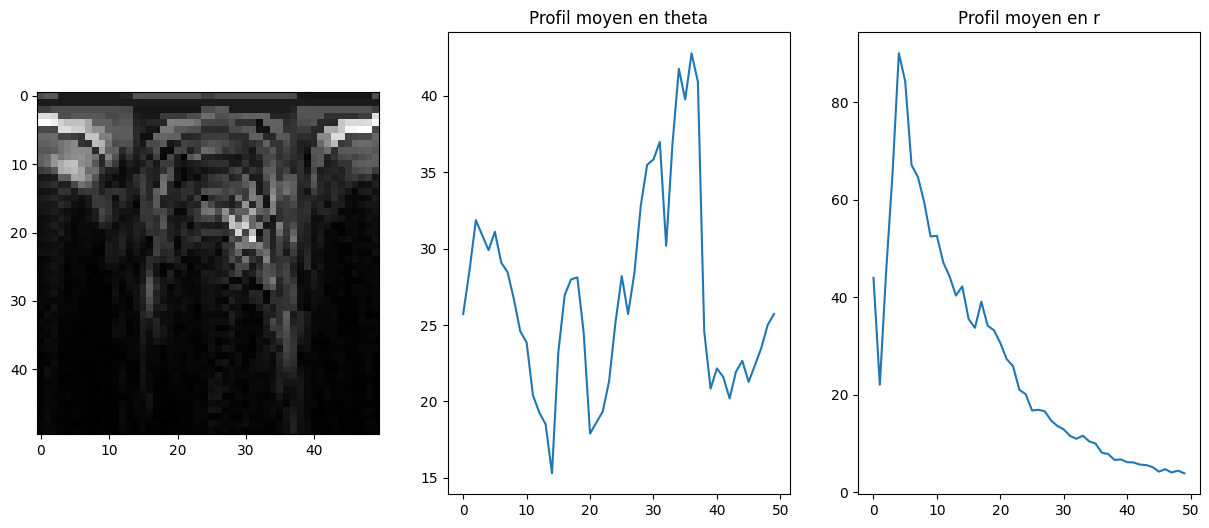

In [21]:
image = random.choice(images)
polar_image, Itheta, Ir = polaire1(image)

print("Vecteur Ir : ", Ir.shape)
print("Vecteur Itheta : ", Itheta.shape)
plt.subplots(1,3,figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow(polar_image, cmap='gray')
plt.subplot(1,3,2)
plt.plot(Itheta)
plt.title("Profil moyen en theta")
plt.subplot(1,3,3)
plt.plot(Ir)
plt.title("Profil moyen en r")
plt.show()

<div class="alert alert-info">
<h3 class="alert-heading"> Question 3 - Invariances des vecteurs $\mathbf{I}_{θ}$ et $\mathbf{I}_{\text{r}}$</h3>

### Invariance par rotation et changement d'échelle

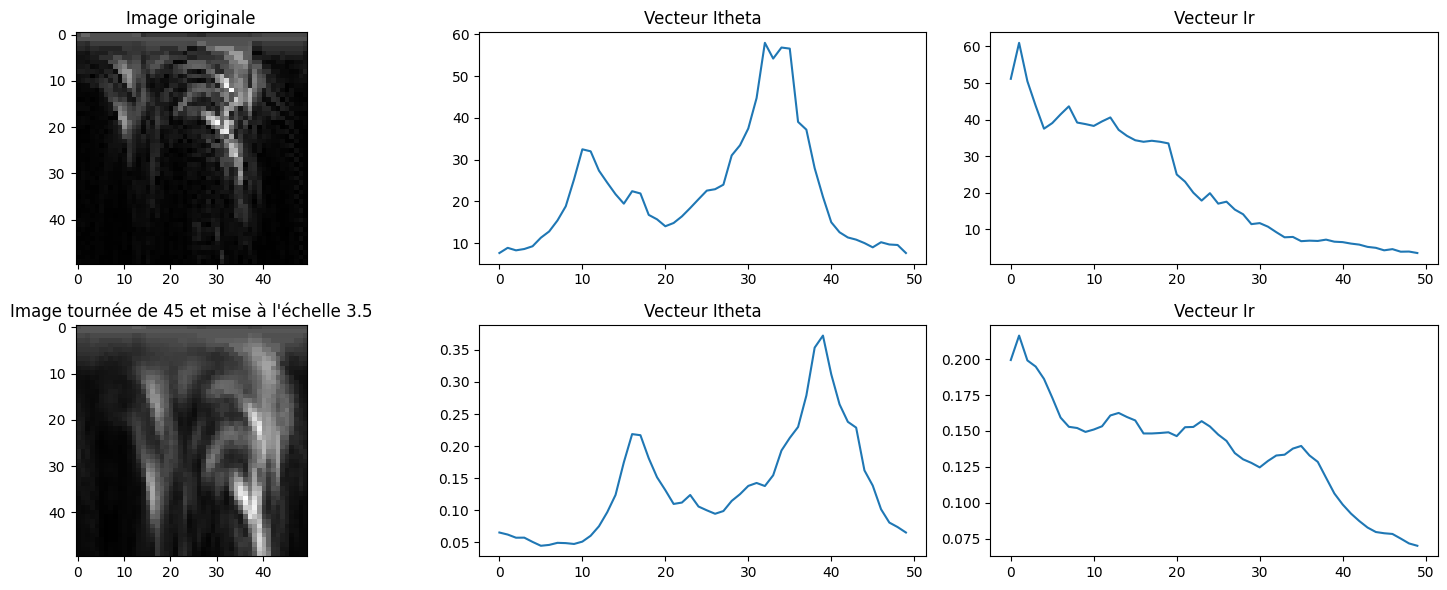

In [22]:
#Changement d'échelle: scale = 3.5
image = random.choice(cropped_images)
original_polar, Itheta_original, Ir_original = polaire1(image)

def scale_image_polar_1(image, scale, Nr, Mtheta, Rmax):
    image_scaled = rescale(image, scale)
    image_polar, Itheta,Ir = polaire1(image_scaled, Nr, Mtheta, Rmax)
    return image_polar, Itheta, Ir

#image_rotated = rotate_image_polar_1(image, 45)
image_rotated = rotate(image, 45)

image_scaled_rotated, Itheta ,Ir= scale_image_polar_1(image_rotated, 2, 50, 50,50 )

# Création des sous-graphiques avec 2 lignes et 3 colonnes
fig, axes = plt.subplots(2, 3, figsize=(15, 6))

# Affichage de l'image originale et ses vecteurs
axes[0, 0].imshow(original_polar, cmap='gray')
axes[0, 0].set_title("Image originale")
axes[0, 1].plot(Itheta_original)
axes[0, 1].set_title("Vecteur Itheta")
axes[0, 2].plot(Ir_original)
axes[0, 2].set_title("Vecteur Ir")

# Affichage de l'image transformée et ses vecteurs
axes[1, 0].imshow(image_scaled_rotated, cmap='gray')
axes[1, 0].set_title("Image tournée de 45 et mise à l'échelle 3.5")
axes[1, 1].plot(Itheta)
axes[1, 1].set_title("Vecteur Itheta")
axes[1, 2].plot(Ir)
axes[1, 2].set_title("Vecteur Ir")


plt.tight_layout()
plt.show()




On observe que les vecteurs $\mathbf{I}_{\text{θ}}$ et $\mathbf{I}_{\text{r}}$ sont les mêmes après les transformation mais ils ont été translatés. Pour garantir une invariance à la translation, on pourrait utiliser diverse techniques comme la corrélation de phase pour calculer la translation inverse entre les deux images. L'idée principale est trouver la similarité entre les spectres de deux images.

### Mesure de distances eucliennes

In [51]:
# Distance euclidienne
image = random.choice(images)

image_rotated = rotate(image, 0, resize=False)
image_rotated_polar, Itheta_rotated, Ir_rotated = polaire1(image_rotated)

image_polar, Itheta, Ir = polaire1(image)
    
def euclidean_distance(v1, v2):
    return np.linalg.norm(v1 - v2)
    
    
# Calcul des distances pour les vecteurs Ir et Itheta
distance_Itheta = euclidean_distance(Itheta, Itheta_rotated)

distance_Ir = euclidean_distance(Ir, Ir_rotated)

# Calcul des distances pour les images polaires
distance_image_polar = euclidean_distance(image_polar, image_rotated_polar)

print("Distance entre les vecteurs Itheta : ", distance_Itheta)
print("Distance entre les vecteurs Ir : ", distance_Ir)
print("Distance entre les images polaires : ", distance_image_polar)



Distance entre les vecteurs Itheta :  200.98273761640118
Distance entre les vecteurs Ir :  255.69302989204172
Distance entre les images polaires :  2117.04748592707


### Commentaires
On constate que les distances euclidiennes entre les vecteurs $\mathbf{I}_{\text{θ}}$ et $\mathbf{I}_{\text{r}}$ sont très faibles. En effet, ces deux vecteurs sont simplement translatés, par rapport aux vecteurs avant rotation. 

#### Cross-correlation pour la rotation

Pour une multitude d'angle, nous allons calculer le $\mathbf{I}_{\text{θ}}$ et calculer la correlation. Ainsi, on pourra tracer la courbe de corrélation en fonction de ${θ}$.


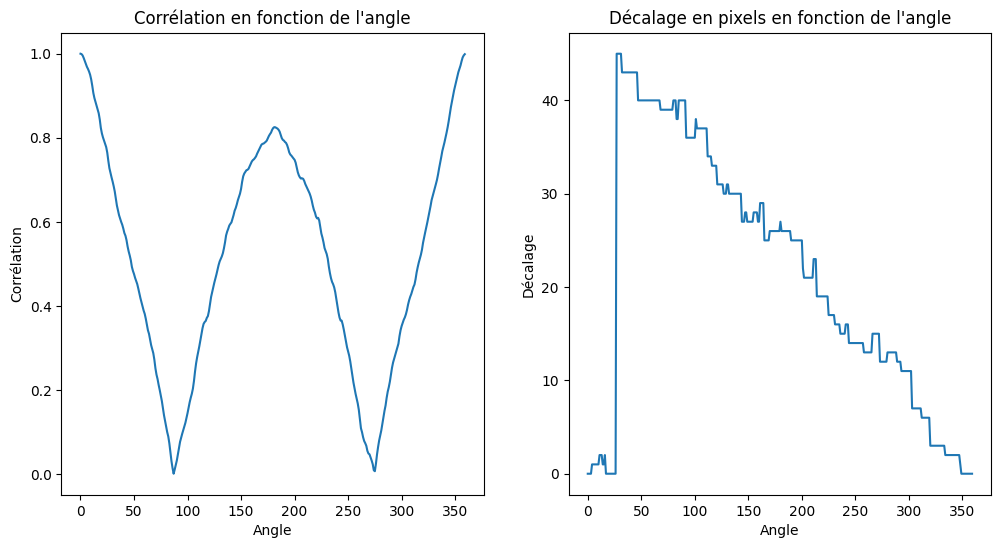

In [24]:
image = random.choice(cropped_images)
image_polar, Itheta, Ir = polaire1(image, Nr=50, Mtheta=50, Rmax=50)

def shift_getter(Itheta, Itheta_rotated):
    corr = np.corrcoef(Itheta, Itheta_rotated)[0,1]
    corr = np.abs(corr)
    shift = np.abs(np.argmin(Itheta)-np.argmin(Itheta_rotated))
    return corr, shift


angles = np.arange(0, 360, 1)
C = np.array([])
S = np.array([])
for angle in angles:
    image_rotated = rotate(image, angle)
    image_rotated_polar, Itheta_rotated, Ir_rotated = polaire1(image_rotated)
    corr, shift = shift_getter(Itheta, Itheta_rotated)
    C = np.append(C,corr)
    S = np.append(S,shift)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(angles, C)
plt.title("Corrélation en fonction de l'angle")
plt.xlabel("Angle")
plt.ylabel("Corrélation")
plt.subplot(1,2,2)
plt.plot(angles, S)
plt.title("Décalage en pixels en fonction de l'angle")
plt.xlabel("Angle")
plt.ylabel("Décalage")
plt.show()

### Commentaires
Le résultat obtenu est cohérent avec ce que l'on attendait. En effet, la corrélation est maximale lorsque les deux images sont identiques, c'est-à-dire lorsque l'angle de rotation est nul. La corrélation diminue lorsque l'angle de rotation augmente, ce qui est logique car les images ne sont plus superposables. Pour un angle de rotation de 180°, la corrélation est également maximale, ce qui évoque une certaine symétrie de l'image



<div class="alert alert-info">
<h3 class="alert-heading"> Question 3.c - Si on prend comme vecteur de caractéristique, l’image polaire et les deux vecteurs de 
projection, quelle est la dimension de l’espace de caractéristiques ? quel est le gain de 
dimension entre cet espace et l’espace initial de l’image ISAR initiale ? </h3>




### Gain de dimension

La dimension d'une image initiale est $M*N$ où $M$ est la hauteur et $N$ la largeur de l'image. Pour une représentation polaire avec comme vecteur caractéristique $\mathbf{I}_{θ}$ et $\mathbf{I}_{\text{r}}$, la dimension peut s'écrite comme suit:

Dimension = Dimension de l'image polaire + Dimension de Itheta + Dimension de Ir, soit :

Dimension = $N_{r}*M_{θ} + N_{r} + M_{θ}$

Donc le gain de dimension s'exprime comme la différence entre la dimension de l'image initiale et la dimension de l'image polaire avec les vecteurs caractéristiques $\mathbf{I}_{θ}$ et $\mathbf{I}_{\text{r}}$ : 

Gain = $100*(M*N - (N_{r}*M_{θ} + N_{r} + M_{θ}))/(M*N) = 96 \% $


---

## Partie III - Classification

<div class="alert alert-info">
<h3 class="alert-heading"> Question 1 - Descripteur</h3>

#### Matrice data


In [25]:

def decripteursBDD(path):
    X, y = load_bdd(path)
    data = []
    for i in range(len(X)):
        _, Itheta, Ir = polaire1(X[i].reshape(150,150))
        data.append([Itheta, Ir])
    return np.array(data), y

data, labels = decripteursBDD(path)
print("Matrice data :", data.shape)
print("Labels :", labels.shape)


Matrice data : (810, 2, 50)
Labels : (810,)




<div class="alert alert-info">
<h3 class="alert-heading"> Question 3 - Classifieur C1</h3>

In [26]:
def reconnaissance(data):
    n_samples = data.shape[0]
    
    # Mélanger aléatoirement les indices des échantillons
    indices = np.random.permutation(n_samples)
    
    # Déterminer le nombre d'échantillons pour l'apprentissage et le test
    n_train = int(2/3 * n_samples)  # 2/3 des données pour l'apprentissage
    n_test = n_samples - n_train                    
    
    # Base d'apprentissage
    X_train = data[indices[:n_train]]
    y_train = label[indices[:n_train]]  # Vecteur de labels pour la base d'apprentissage
    
    # Base de test
    X_test = data[indices[n_train:]]
    y_test = label[indices[n_train:]]
    
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)


# Utilisation de la fonction reconnaissance
X_train, y_train, X_test, y_test = reconnaissance(data)

# Affichage des tailles des ensembles
print("Taille de la base d'apprentissage :", X_train.shape)
print("Taille vecteur de labels de la base d'apprentissage :", y_train.shape)
print("Taille de la base de test :", X_test.shape)
print("Taille vecteur de labels de la base de test :", y_test.shape)

Taille de la base d'apprentissage : (540, 2, 50)
Taille vecteur de labels de la base d'apprentissage : (540,)
Taille de la base de test : (270, 2, 50)
Taille vecteur de labels de la base de test : (270,)


In [27]:
def classifieurC1_Ir(BA, BT, n_neigh):
    # Création du classifieur KNN
    knn = KNeighborsClassifier(n_neighbors=n_neigh)
    knn.fit(BA[:,1,:], y_train)  # Entraînement sur la caractéristique Ir

    # Prédiction sur la base de test
    y_pred = knn.predict(BT[:,1,:])
    distances, _ = knn.kneighbors(BT[:,1,:], n_neighbors=n_neigh, return_distance=True)  
    
    accuracy = sk.metrics.accuracy_score(y_test, y_pred) * 100
    return y_pred, accuracy, distances


k_values = [1, 3, 5]
for k in k_values:
    start_time = time.perf_counter()  # Enregistrement du temps de début
    y_pred_test, taux, distances = classifieurC1_Ir(X_train, X_test, n_neigh=k)
    end_time = time.perf_counter()  # Enregistrement du temps de fin

    print("-------------------------------------------------------------------------------")
    # Affichage des prédictions et du taux de classification
    print(f"Taux de classification pour k={k}: \n > {taux:.4f}%")
    print(f"Temps d'exécution pour k={k}: \n > {end_time - start_time:.4f} secondes")
    # Affichage de la matrice de distances pour le premier échantillon de la base de test
    print(f"Matrice de distances pour k={k} : \n > {distances[0]}")
    print("-------------------------------------------------------------------------------")

    print("\n")


-------------------------------------------------------------------------------
Taux de classification pour k=1: 
 > 99.6296%
Temps d'exécution pour k=1: 
 > 0.2073 secondes
Matrice de distances pour k=1 : 
 > [0.0348396]
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Taux de classification pour k=3: 
 > 98.5185%
Temps d'exécution pour k=3: 
 > 0.0223 secondes
Matrice de distances pour k=3 : 
 > [0.0348396  0.04092156 0.0434744 ]
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Taux de classification pour k=5: 
 > 97.0370%
Temps d'exécution pour k=5: 
 > 0.0257 secondes
Matrice de distances pour k=5 : 
 > [0.0348396  0.04092156 0.0434744  0.05848709 0.06228572]
-------------------------------------------------------------------------------




### Commentaire 
Pour une classification avec le vecteur $\mathbf{I}_{\text{r}}$ comme seule caractéristique, nous obtenons un taux de classification qui diminue pour un nombre de voisins qui augmente. Ce premier résultat est cohérent avec ce que l'on attendait, car un nombre de voisins élevé peut entraîner une perte d'information. 

In [28]:
import time 
def classifieurC1_Itheta(BA, BT, n_neigh):
    # Création du classifieur KNN
    knn = KNeighborsClassifier(n_neighbors=n_neigh)
    knn.fit(BA[:,0,:], y_train)  # Entraînement sur la caractéristique Itheta

    # Prédiction sur la base de test
    y_pred = knn.predict(BT[:,0,:])
    distances, indices = knn.kneighbors(BT[:,0,:], n_neighbors=n_neigh, return_distance=True)  
    
    accuracy = sk.metrics.accuracy_score(y_test, y_pred) * 100
    return indices, accuracy, distances


k_values = [1, 3, 5]
for k in k_values:
    start_time = time.perf_counter()  # Enregistrement du temps de début
    y_pred_test, taux, distances = classifieurC1_Itheta(X_train, X_test, n_neigh=k)
    end_time = time.perf_counter() 

    print("-------------------------------------------------------------------------------")
    # Affichage des prédictions et du taux de classification
    print(f"Taux de classification pour k={k}: \n > {taux:.4f}%")
    print(f"Temps d'exécution pour k={k}: \n > {end_time - start_time:.4f} secondes")
    # Affichage de la matrice de distances pour le premier échantillon de la base de test
    print(f"Matrice de distances pour k={k} : \n > {distances[0]}")
    print("-------------------------------------------------------------------------------")

    print("\n")


-------------------------------------------------------------------------------
Taux de classification pour k=1: 
 > 100.0000%
Temps d'exécution pour k=1: 
 > 0.0336 secondes
Matrice de distances pour k=1 : 
 > [0.02136589]
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Taux de classification pour k=3: 
 > 100.0000%
Temps d'exécution pour k=3: 
 > 0.0247 secondes
Matrice de distances pour k=3 : 
 > [0.02136589 0.02234771 0.02973666]
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Taux de classification pour k=5: 
 > 100.0000%
Temps d'exécution pour k=5: 
 > 0.0208 secondes
Matrice de distances pour k=5 : 
 > [0.02136589 0.02234771 0.02973666 0.03425512 0.04637642]
-------------------------------------------------------------------------------




### Commentaires

Nous remarquons que pour un classifieur n'utilisant que le vecteur $\mathbf{I}_{\text{θ}}$ comme caractéristique, le taux de classification est plus élevé que pour le vecteur $\mathbf{I}_{\text{r}}$. Cela peut indiquer un certain sur-apprentissage du modèle, car le vecteur $\mathbf{I}_{\text{θ}}$ contient plus d'informations que le vecteur $\mathbf{I}_{\text{r}}$.

In [29]:
def classifieurC1_II(BA,BT,n_neigh):
    # Concaténation des caractéristiques Itheta et Ir
    BA_combined = np.hstack((BA[:, 0, :], BA[:, 1, :]))
    BT_combined = np.hstack((BT[:, 0, :], BT[:, 1, :]))

    # Création du classifieur KNN
    knn = KNeighborsClassifier(n_neighbors=n_neigh)
    knn.fit(BA_combined, y_train) 

    # Prédiction sur la base de test
    y_pred = knn.predict(BT_combined)
    distances, indices = knn.kneighbors(BT_combined, n_neighbors=n_neigh, return_distance=True)  
    accuracy = sk.metrics.accuracy_score(y_test, y_pred) * 100

    # retourner un pourcentage λ% du vecteur d'indices
    indices = np.array(indices.flatten())
    indices = indices[:int(len(indices) * 0.3)]

    return indices, accuracy, distances


k_values = [1, 3, 5]
for k in k_values:
    start_time = time.perf_counter()  # Enregistrement du temps de début
    y_pred_test, taux, distances = classifieurC1_II(X_train, X_test, n_neigh=k)
    end_time = time.perf_counter()

    print("-------------------------------------------------------------------------------")
    # Affichage des prédictions et du taux de classification
    print(f"Taux de classification pour k={k}: \n > {taux:.4f}%")
    print(f"Temps d'exécution pour k={k}: \n > {end_time-start_time:.4f} secondes")
    # Affichage de la matrice de distances pour le premier échantillon de la base de test
    print(f"Matrice de distances pour k={k} : \n > {distances[0]}")
    print(" > Nombre d'indices : ", y_pred_test.shape)
    print("-------------------------------------------------------------------------------")
    print("\n")



-------------------------------------------------------------------------------


Taux de classification pour k=1: 
 > 100.0000%
Temps d'exécution pour k=1: 
 > 0.0137 secondes
Matrice de distances pour k=1 : 
 > [0.04086929]
 > Nombre d'indices :  (81,)
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Taux de classification pour k=3: 
 > 100.0000%
Temps d'exécution pour k=3: 
 > 0.0300 secondes
Matrice de distances pour k=3 : 
 > [0.04086929 0.04888194 0.05058501]
 > Nombre d'indices :  (243,)
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Taux de classification pour k=5: 
 > 99.2593%
Temps d'exécution pour k=5: 
 > 0.0190 secondes
Matrice de distances pour k=5 : 
 > [0.04086929 0.04888194 0.05058501 0.07108392 0.07995062]
 > Nombre d'indices :  (405,)
-------------------------------------------------------------------------------




### Commentaires

TODO : Commenter cette section (pourquoi on a ces résultats ? )

<div class="alert alert-info">
<h3 class="alert-heading"> Question 5 - Classifieur C2 </h3>

In [30]:

def classifieurC2_Itheta(BA, BT, n_neigh):
    # Création du classifieur KNN
    knn = KNeighborsClassifier(n_neighbors=n_neigh)
    knn.fit(BA[:,0,:], y_train)  # Entraînement sur la caractéristique Itheta

    # Prédiction sur la base de test
    y_pred = knn.predict(BT[:,0,:])
    distances, indices = knn.kneighbors(BT[:,0,:], n_neighbors=n_neigh, return_distance=True)  
    
    accuracy = sk.metrics.accuracy_score(y_test, y_pred) * 100
    return indices, accuracy, distances

S1, taux, distances = classifieurC1_II(X_train, X_test, n_neigh=1)

# Bases d'apprentissage et de test pour le classifieur C2 ne contenants que les échantillons sélectionnés
data_s1 = []
for i in range(len(S1)):
    _, Itheta, Ir = polaire1(cropped_images[int(S[i])])
    data_s1.append([Itheta, Ir])
data_s1 = np.array(data_s1)
X_train_c2, y_train_c2, X_test_c2, y_test_c2 = reconnaissance(data_s1)

k_values = [1, 3, 5]
for k in k_values:
    start_time = time.perf_counter()  # Enregistrement du temps de début
    y_pred_test, taux, distances = classifieurC2_Itheta(X_train, X_test, n_neigh=k)
    end_time = time.perf_counter()

    print("-------------------------------------------------------------------------------")
    # Affichage des prédictions et du taux de classification
    print(f"Taux de classification pour k={k}: \n > {taux:.4f}%")
    print(f"Temps d'exécution pour k={k}: \n > {end_time-start_time:.4f} secondes")
    # Affichage de la matrice de distances pour le premier échantillon de la base de test
    print(f"Matrice de distances pour k={k} : \n > {distances[0]}")
    print("-------------------------------------------------------------------------------")
    print("\n")



-------------------------------------------------------------------------------
Taux de classification pour k=1: 
 > 100.0000%
Temps d'exécution pour k=1: 
 > 0.0250 secondes
Matrice de distances pour k=1 : 
 > [0.02136589]
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Taux de classification pour k=3: 
 > 100.0000%
Temps d'exécution pour k=3: 
 > 0.0276 secondes
Matrice de distances pour k=3 : 
 > [0.02136589 0.02234771 0.02973666]
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Taux de classification pour k=5: 
 > 100.0000%
Temps d'exécution pour k=5: 
 > 0.0245 secondes
Matrice de distances pour k=5 : 
 > [0.02136589 0.02234771 0.02973666 0.03425512 0.04637642]
-------------------------------------------------------------------------------




<div class="alert alert-info">
<h3 class="alert-heading"> Question 6 - Rotation et changement d'échelle </h3>